<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Detection Project




This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

<img src="https://github.com/wingated/cs474_labs/blob/master/images/pos_test_000072.png?raw=true" width="200">



## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory)
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).



---

I used the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf)

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)



In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime.

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)

  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]

  def __len__(self):
    return len(self.dataset_folder)

In [ ]:

# TODO: You need to change this to fit the UNet structure!!!
class CancerDetection(nn.Module):
  def __init__(self, dataset): # CancerDetection constructor
    # You always need to use super to call nn.Module's init function when creating a class that inherits nn.Module.
    super(CancerDetection, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()

    # Down the U
    # Top Layers
    self.convT1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1)
    self.reluT2 = nn.ReLU()
    self.convT3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)
    self.reluT4 = nn.ReLU()
    self.max_poolT5 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Top Middle Layers
    self.convTM1 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 1)
    self.reluTM2 = nn.ReLU()
    self.convTM3 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)
    self.reluTM4 = nn.ReLU()
    self.max_poolTM5 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Middle Layers
    self.convM1 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 1)
    self.reluM2 = nn.ReLU()
    self.convM3 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)
    self.reluM4 = nn.ReLU()
    self.max_poolM5 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Bottom Middle Layers
    self.convBM1 = nn.Conv2d(256,512,kernel_size = 3, stride = 1, padding = 1)
    self.reluBM2 = nn.ReLU()
    self.convBM3 = nn.Conv2d(512,512,kernel_size = 3, stride = 1, padding = 1)
    self.reluBM4 = nn.ReLU()
    self.max_poolBM5 = nn.MaxPool2d(kernel_size=2, stride=2)

    #Bottom Layers
    self.convB1 = nn.Conv2d(512,1024,kernel_size = 3, stride = 1, padding = 1)
    self.reluB2 = nn.ReLU()
    self.convB3 = nn.Conv2d(1024,1024,kernel_size = 3, stride = 1, padding = 1)
    self.reluB4 = nn.ReLU()
    self.conv_upB5 = nn.ConvTranspose2d(1024,512,kernel_size=2, stride= 2)

    #Up the U
    #Bottom Middle Layers
    self.convBMU1 = nn.Conv2d(1024,512,kernel_size = 3, stride = 1, padding = 1)
    self.reluBMU2 = nn.ReLU()
    self.convBMU3 = nn.Conv2d(512,512,kernel_size = 3, stride = 1, padding = 1)
    self.reluBMU4 = nn.ReLU()
    self.conv_upBMU = nn.ConvTranspose2d(512,256,kernel_size=2, stride= 2)

    #Middle Layers
    self.convMU1 = nn.Conv2d(512,256,kernel_size = 3, stride = 1, padding = 1)
    self.reluMU2 = nn.ReLU()
    self.convMU3 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)
    self.reluMU4 = nn.ReLU()
    self.conv_upMU = nn.ConvTranspose2d(256,128,kernel_size=2, stride= 2)

    #Top Middle Layers
    self.convTMU1 = nn.Conv2d(256,128,kernel_size = 3, stride = 1, padding = 1)
    self.reluTMU2 = nn.ReLU()
    self.convTMU3 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)
    self.reluTMU4 = nn.ReLU()
    self.conv_upTMU = nn.ConvTranspose2d(128,64,kernel_size=2, stride= 2)

    #Top Layers
    self.convTU1 = nn.Conv2d(128,64,kernel_size = 3, stride = 1, padding = 1)
    self.reluTU2 = nn.ReLU()
    self.convTU3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)
    self.reluTU4 = nn.ReLU()
    self.conv_final = nn.Conv2d(64,2,kernel_size = 3, stride = 1, padding = 1)



  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)
    # Down the U
    # Top Layers
    convT1_out = self.convT1(input)
    reluT2_out = self.reluT2(convT1_out)
    convT3_out = self.convT3(reluT2_out)
    reluT4_out = self.reluT4(convT3_out)
    max_pool_outT = self.max_poolT5(reluT4_out)

    #Top Middle Layers
    convTM1_out = self.convTM1(max_pool_outT)
    reluTM2_out = self.reluTM2(convTM1_out)
    convTM3_out = self.convTM3(reluTM2_out)
    reluTM4_out = self.reluTM4(convTM3_out)
    max_pool_outTM = self.max_poolTM5(reluTM4_out)

    #Middle Layers
    convM1_out = self.convM1(max_pool_outTM)
    reluM2_out = self.reluM2(convM1_out)
    convM3_out = self.convM3(reluM2_out)
    reluM4_out = self.reluM4(convM3_out)
    max_pool_outM = self.max_poolM5(reluM4_out)

    #Bottom Middle Layers
    convBM1_out = self.convBM1(max_pool_outM)
    reluBM2_out = self.reluBM2(convBM1_out)
    convBM3_out = self.convBM3(reluBM2_out)
    reluBM4_out = self.reluBM4(convBM3_out)
    max_pool_outBM = self.max_poolBM5(reluBM4_out)

    #Bottom Layers
    convB1_out = self.convB1(max_pool_outBM)
    reluB2_out = self.reluB2(convB1_out)
    convB3_out = self.convB3(reluB2_out)
    reluB4_out = self.reluB4(convB3_out)
    conv_upB_out = self.conv_upB5(reluB4_out)

    catBM = torch.cat((reluBM4_out,conv_upB_out),1)

    #Up the U
    #Bottom Middle Layers
    convBMU1_out = self.convBMU1(catBM)
    reluBMU2_out = self.reluBMU2(convBMU1_out)
    convBMU3_out = self.convBMU3(reluBMU2_out)
    reluBMU4_out = self.reluBMU4(convBMU3_out)
    conv_BMUup_out = self.conv_upBMU(reluBMU4_out)

    catM = torch.cat((reluM4_out,conv_BMUup_out),1)

    # Middle Layers
    convMU1_out = self.convMU1(catM)
    reluMU2_out = self.reluMU2(convMU1_out)
    convMU3_out = self.convMU3(reluMU2_out)
    reluMU4_out = self.reluMU4(convMU3_out)
    conv_MUup_out = self.conv_upMU(reluMU4_out)

    catTM = torch.cat((reluTM4_out,conv_MUup_out),1)

     # Top Middle Layers
    convTMU1_out = self.convTMU1(catTM)
    reluTMU2_out = self.reluTMU2(convTMU1_out)
    convTMU3_out = self.convTMU3(reluTMU2_out)
    reluTMU4_out = self.reluTMU4(convTMU3_out)
    conv_TMUup_out = self.conv_upTMU(reluTMU4_out)

    catT = torch.cat((reluT4_out,conv_TMUup_out),1)

     # Top Layers
    convTU1_out = self.convTU1(catT)
    reluTU2_out = self.reluTU2(convTU1_out)
    convTU3_out = self.convTU3(reluTU2_out)
    reluTU4_out = self.reluTU4(convTU3_out)
    conv_final_out = self.conv_final(reluTU4_out)




    return conv_final_out


In [ ]:

losses = []
validations = []
accuracies = []
images = []

def scope():
  try:
    # code for calling dataset and dataloader

    train_dataset = CancerDataset('/tmp/CancerDataset')
    val_dataset = CancerDataset('/tmp/CancerDataset', train=False)


    train_loader = DataLoader(train_dataset, batch_size=5, num_workers=2, pin_memory=True, shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=5, num_workers=2, pin_memory=True)

    #for epochs:
    # Call model, figure out loss and accuracy
    model = CancerDetection(train_dataset)
    model.cuda()


    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    objective = torch.nn.CrossEntropyLoss()

    gc.collect()

    num_epochs = 5
    for epoch in range(num_epochs):

      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch,(x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(), y_truth.cuda()

        optimizer.zero_grad()

        y_hat = model(x)
        loss = objective(y_hat, y_truth.long())
        loss.backward()

        losses.append(loss.item())
        accuracy = ((torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean())
        accuracies.append(accuracy.item())
        mem = torch.cuda.memory_allocated() / 1e5
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.3f}'.format(epoch, loss, accuracy, mem))
        loop.update(1)

        optimizer.step()

        if batch % 15 == 0:
          val = np.mean([objective(model(x.cuda()),y.long().cuda()).item()
                      for x, y in validation_loader])
          validations.append((len(losses), val))


      images.append(model(val_dataset[172][0].unsqueeze(0).cuda()))
      loop.close()


  except:
    __ITB__()

scope()




___

### Part 2

Plot performance over time



In [ ]:
gc.collect()
print(torch.cuda.memory_allocated() / 1e5)

45736.42752


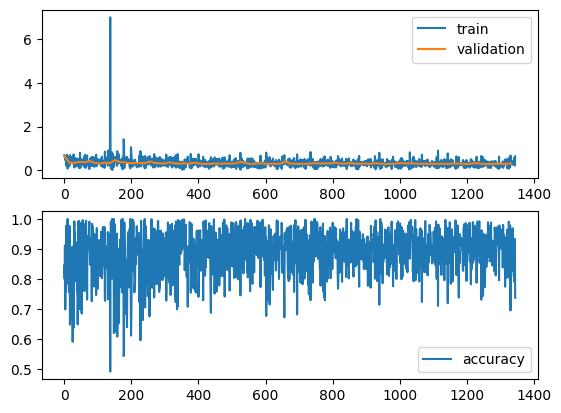

In [ ]:
# plotting code here
fig , axs = plt.subplots(2,1)

a, b = zip(*validations)
axs[0].plot(losses, label='train')
axs[0].plot(a, b, label = 'validation')
axs[1].plot(accuracies, label = 'accuracy')
axs[0].legend()
axs[1].legend()

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images.




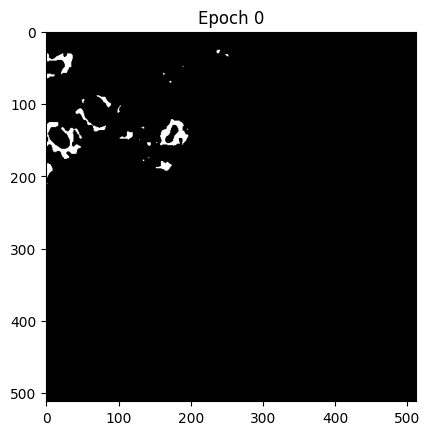

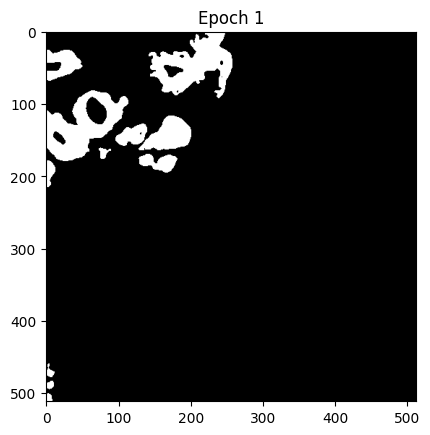

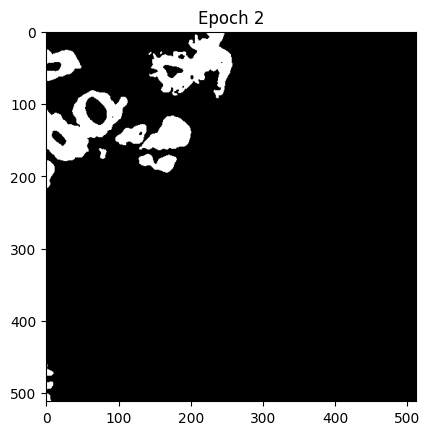

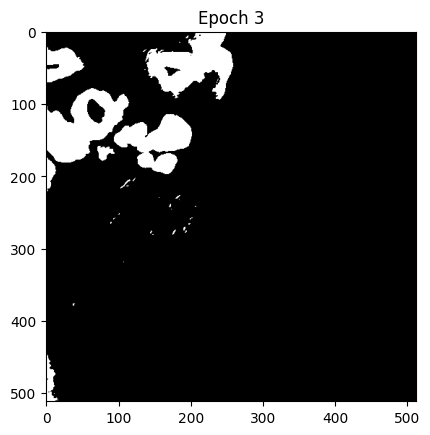

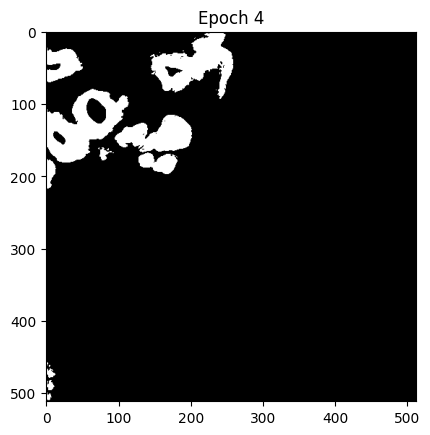

In [ ]:
# Code for testing prediction on an image
for i , j in enumerate(images):
  plt.imshow(j.squeeze(0).argmax(0).cpu().detach().numpy(), cmap='gray')
  plt.title(f"Epoch {i}")
  plt.show()